# COVID-19 Risk Classification Project Visualizations

## Introduction
This notebook will provide visualizations to:
- Showcase key COVID trends in the U.S.
- Validate out quantile-based risk levels
- Present model performance (including ROC curves, confusion matrices, feature importances)

## Setup

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc,
    ConfusionMatrixDisplay
)
import joblib  # for loading trained models
%matplotlib inline

# Load engineered dataset (features + composite_index + risk_label)
df = pd.read_csv('../data/us_covid_features_and_labels_cleaned.csv', parse_dates=['date'])
print("Data shape:", df.shape)
display(df.head())
df.info()

Data shape: (1653, 77)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,7_day_avg_deaths,roll_cases,roll_deaths,roll_icu,roll_hosp,pctchg_cases,pctchg_deaths,composite_index,risk_label,month
0,USA,North America,United States,2020-01-26,7.0,7.0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2020-01
1,USA,North America,United States,2020-01-27,7.0,0.0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,-1.0,0.0,NaN,NaN,2020-01
2,USA,North America,United States,2020-01-28,7.0,0.0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2020-01
3,USA,North America,United States,2020-01-29,7.0,0.0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2020-01
4,USA,North America,United States,2020-01-30,7.0,0.0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2020-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1653 entries, 0 to 1652
Data columns (total 77 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   iso_code                                    1653 non-null   object        
 1   continent                                   1653 non-null   object        
 2   location                                    1653 non-null   object        
 3   date                                        1653 non-null   datetime64[ns]
 4   total_cases                                 1653 non-null   float64       
 5   new_cases                                   1653 non-null   float64       
 6   new_cases_smoothed                          1211 non-null   float64       
 7   total_deaths                                1653 non-null   float64       
 8   new_deaths                                  1653 non-null   float64       
 9   new_deat

## Prepare Data for Visualization

In [79]:
# Drop rows with missing engineered features or labels
df = df.dropna(subset=[
    'new_cases','roll_cases','composite_index','risk_label'
])
# Ensure risk_label is categorical
df['risk_label'] = df['risk_label'].astype('category')

## Univariate Distributions

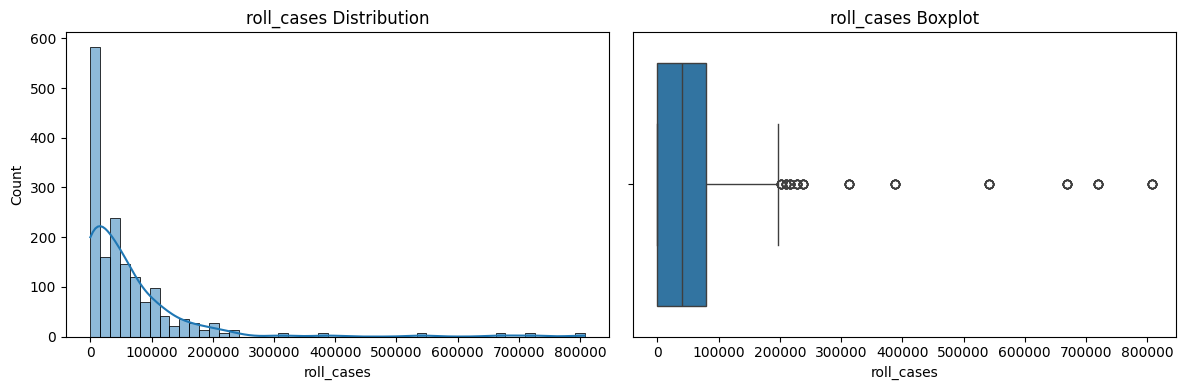

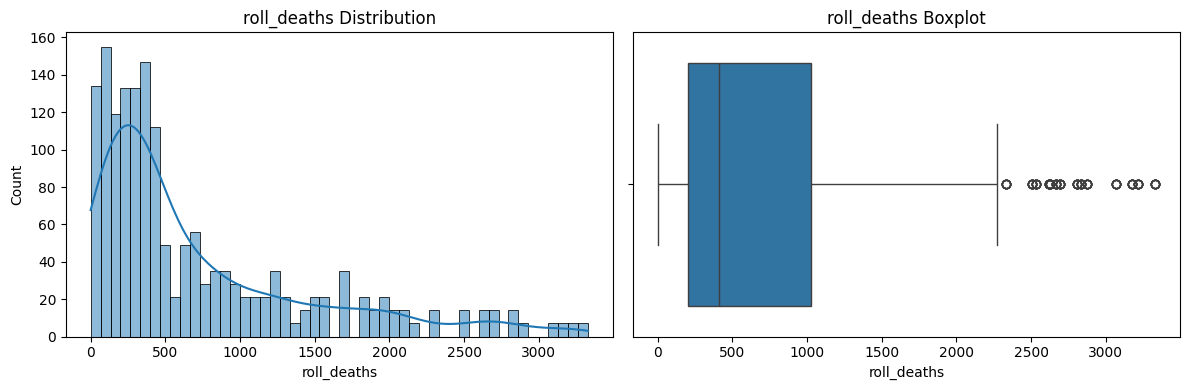

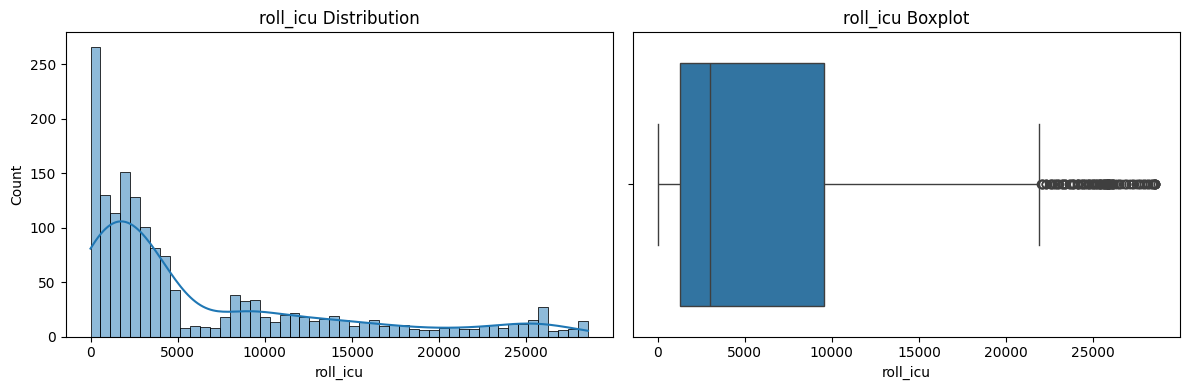

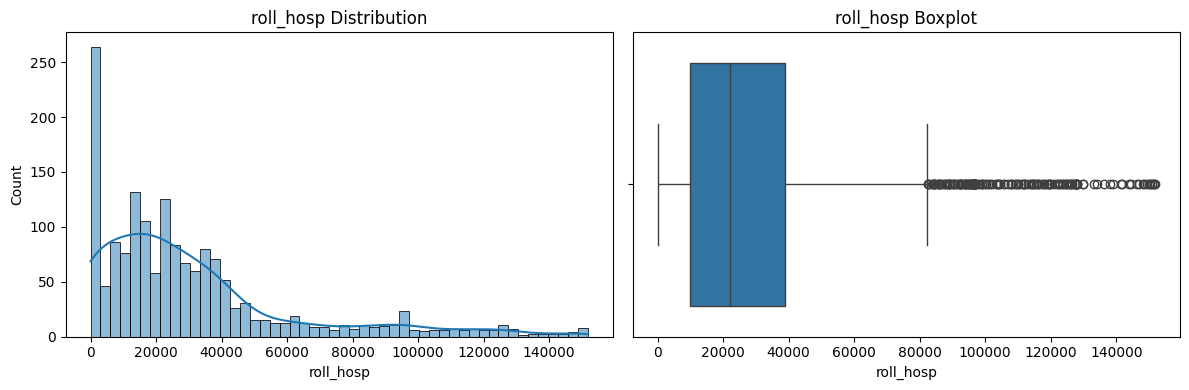

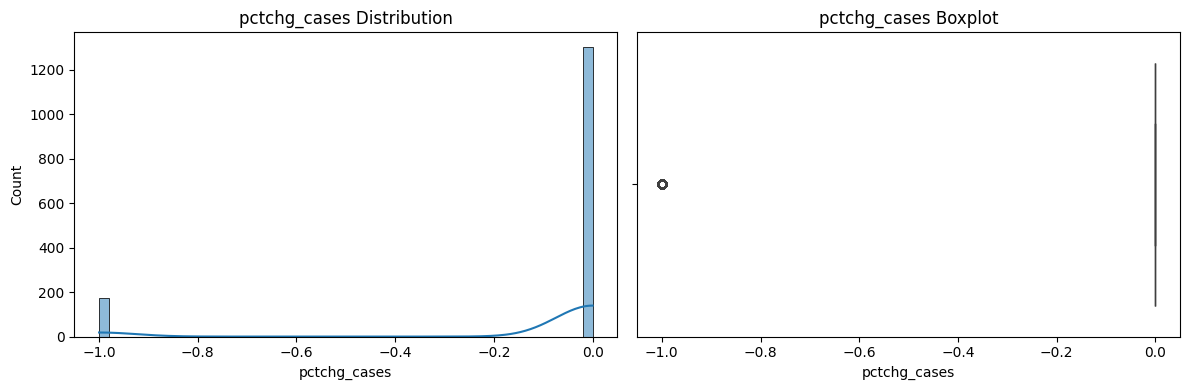

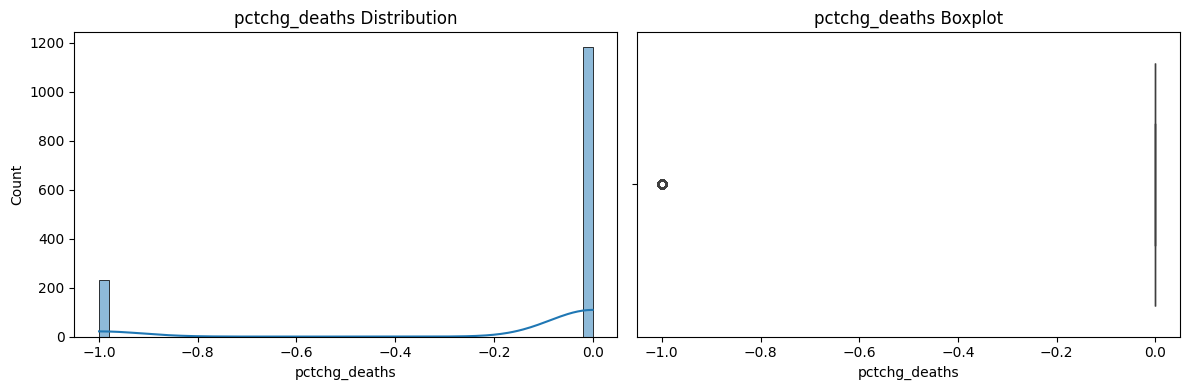

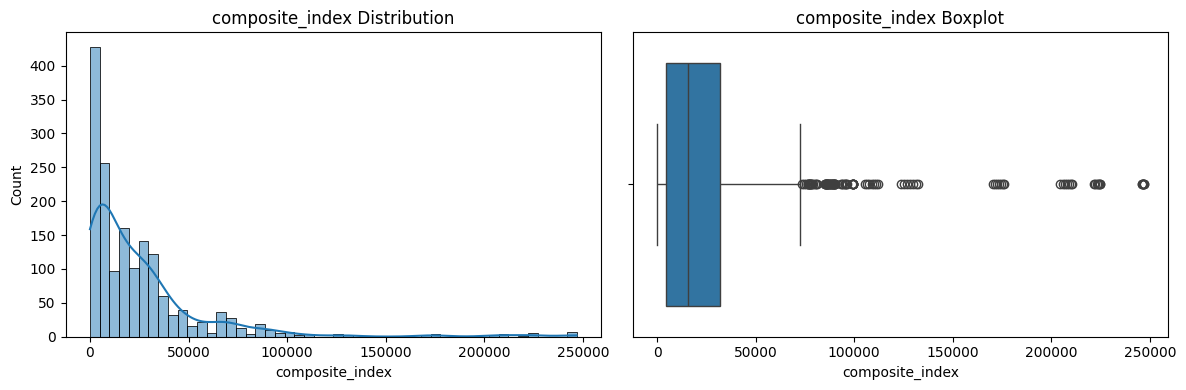

In [80]:
features = [
    'roll_cases','roll_deaths','roll_icu','roll_hosp',
    'pctchg_cases','pctchg_deaths','composite_index'
]

for col in features:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(df[col], bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f'{col} Distribution')
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f'{col} Boxplot')
    plt.tight_layout()
    plt.show()


## Risk-Label Distribution

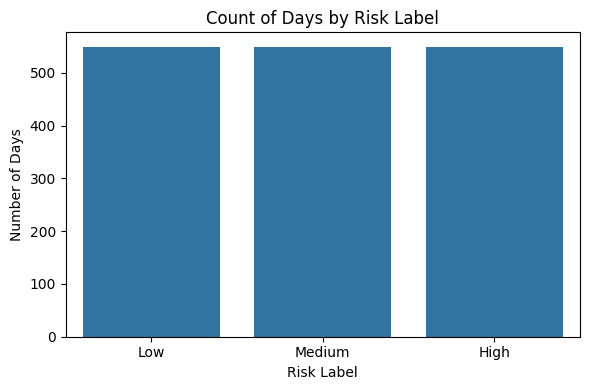

In [81]:
plt.figure(figsize=(6,4))
sns.countplot(x='risk_label', data=df, order=['Low','Medium','High'])
plt.title('Count of Days by Risk Label')
plt.xlabel('Risk Label')
plt.ylabel('Number of Days')
plt.tight_layout()
plt.show()


## Time-Series Trends
### 1 Daily vs. 7-Day Averages

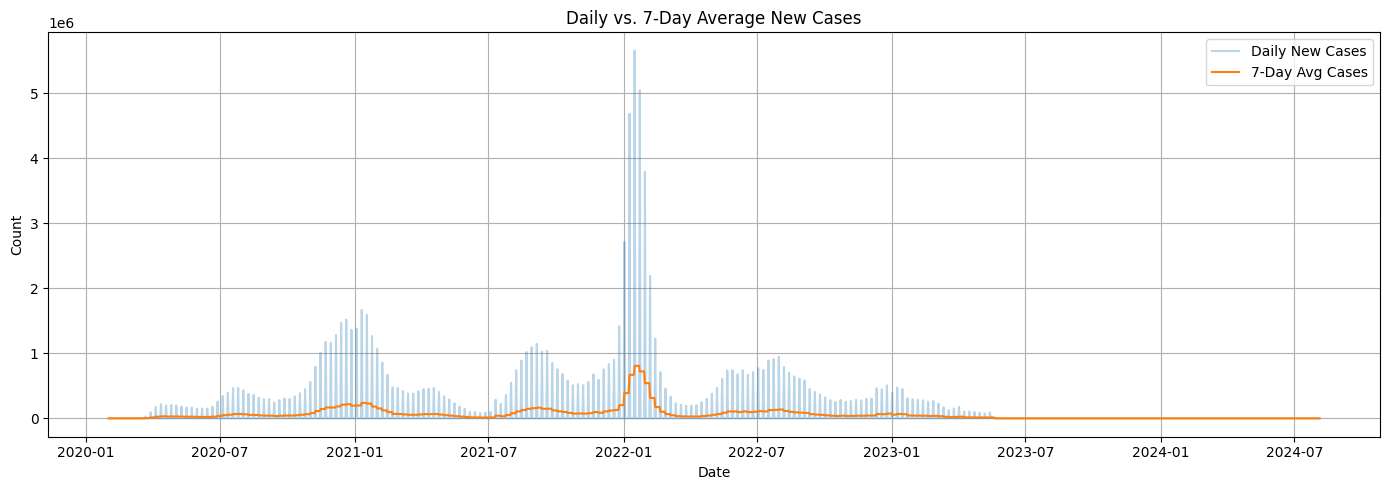

In [82]:
plt.figure(figsize=(14,5))
plt.plot(df['date'], df['new_cases'], alpha=0.3, label='Daily New Cases')
plt.plot(df['date'], df['roll_cases'],   label='7-Day Avg Cases')
plt.title('Daily vs. 7-Day Average New Cases')
plt.xlabel('Date'); plt.ylabel('Count')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


### Composite Risk Over Time

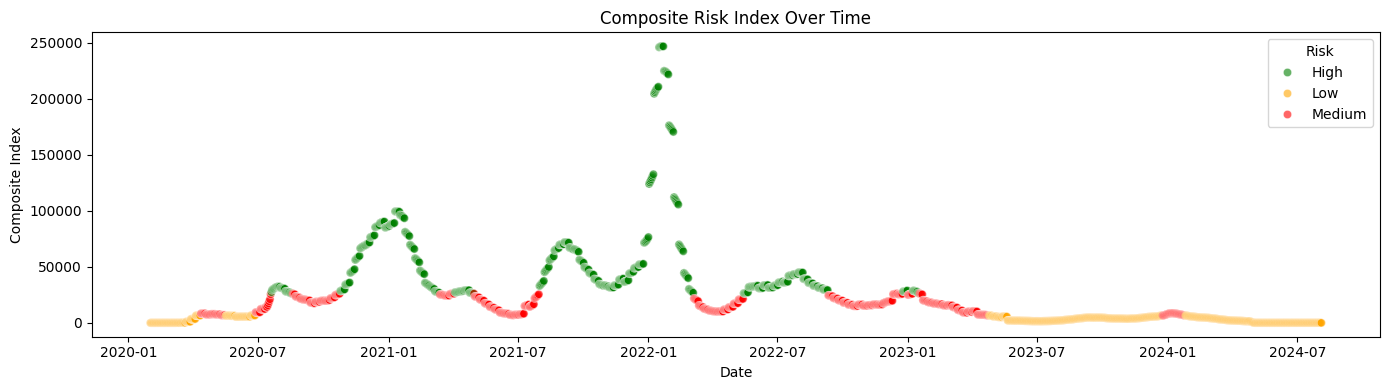

In [83]:
plt.figure(figsize=(14,4))
sns.scatterplot(
    data=df, x='date', y='composite_index',
    hue='risk_label', palette=['green','orange','red'],
    alpha=0.6
)
plt.title('Composite Risk Index Over Time')
plt.xlabel('Date'); plt.ylabel('Composite Index')
plt.legend(title='Risk'); plt.tight_layout()
plt.show()


### Visualize Model Performance

In [84]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Load test split and trained models
X_test = joblib.load('../models/X_test.pkl')
y_test = joblib.load('../models/y_test.pkl')

models = {
    'RandomForest': joblib.load('../models/best_rf.pkl'),
    'SVM'         : joblib.load('../models/best_svm.pkl'),
    'XGBoost'     : joblib.load('../models/best_xgb.pkl'),
    'DecisionTree': joblib.load('../models/best_tree.pkl'),
    'LogisticReg' : joblib.load('../models/best_logreg.pkl'),
}

high_code = 2  


### ROC Curves

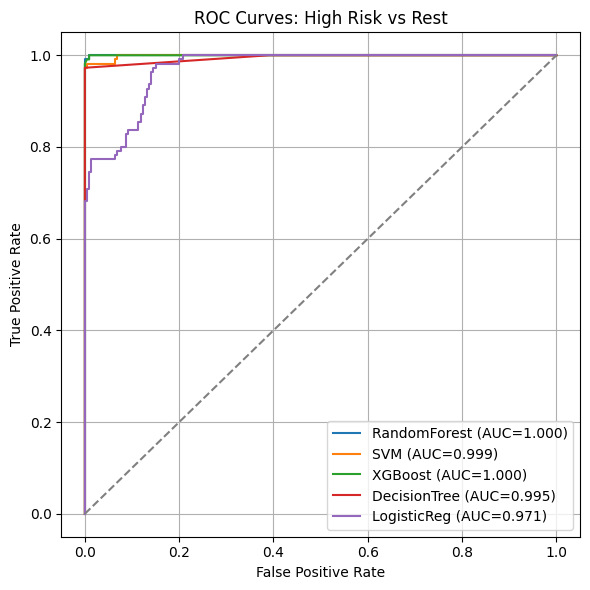

In [85]:
plt.figure(figsize=(6,6))
for name, mdl in models.items():
    # get probability for the "High" class
    y_proba = mdl.predict_proba(X_test)[:, list(mdl.classes_).index(high_code)]
    fpr, tpr, _ = roc_curve((y_test == high_code).astype(int), y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr, tpr):.3f})')

plt.plot([0,1], [0,1], '--', color='gray')
plt.title('ROC Curves: High Risk vs Rest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


### Confusion Matrix -- Random Forest

<Figure size 500x500 with 0 Axes>

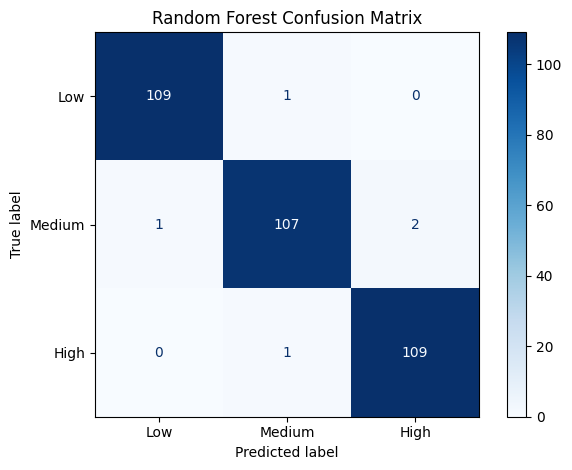

In [86]:
plt.figure(figsize=(5,5))
ConfusionMatrixDisplay.from_estimator(
    models['RandomForest'], X_test, y_test,
    display_labels=['Low','Medium','High'],
    cmap='Blues'
)
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()


### Feature Importances

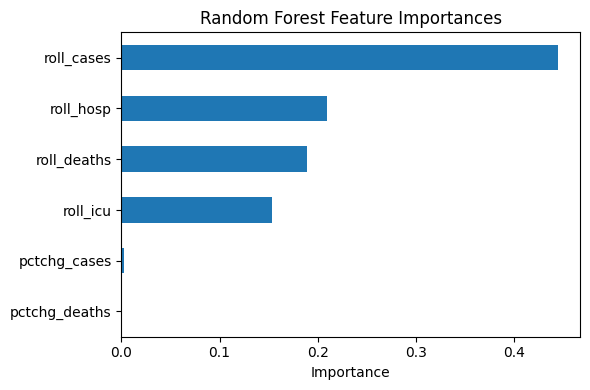

In [87]:
importances = pd.Series(
    models['RandomForest'].named_steps['clf'].feature_importances_,
    index=X_test.columns
).sort_values()
importances.plot.barh(figsize=(6,4))
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

